In [18]:
import os
import re
from pathlib import Path
from typing import Any, Dict, Iterable, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes

sns.set_style("whitegrid")

class GridPlotter:
    nrows: int
    ncols: int
    tight_layout: bool
    kwargs: Dict[str, Any]

    _counter: int
    _axs: Optional[Union[Axes, np.ndarray]]
    _fig: Optional[plt.Figure]

    def __init__(
        self, nrows: int = 1, ncols: int = 1, tight_layout: bool = True, **kwargs
    ):
        if nrows <= 0 and ncols <= 0:
            raise ValueError("Either nrows or ncols must be positive.")
        self.nrows = nrows
        self.ncols = ncols
        self.tight_layout = tight_layout
        self.kwargs = kwargs

        self._counter = 0
        self._axs = None
        self._fig = None

    def iteraxs(self, count: int = -1) -> Iterable[Axes]:
        self.reset()
        nrows, ncols = self.get_grid_shape(count)
        fig, axs = plt.subplots(nrows, ncols, **self.kwargs)
        self._fig, self._axs = fig, axs
        if self.tight_layout:
            fig.tight_layout()

        if isinstance(axs, np.ndarray):
            if axs.ndim == 1:
                for i in range(max(ncols, nrows)):
                    if self._counter == count:
                        break
                    self._counter += 1
                    yield axs[i]
            else:
                for i in range(nrows):
                    for j in range(ncols):
                        if self._counter == count:
                            break
                        self._counter += 1
                        yield axs[i, j]
        else:
            self._counter += 1
            yield axs

    def show(self):
        if self._fig is None:
            raise ValueError("No figure to save.")
        self.finish()
        self._fig.show()
        self.reset()
    
    def savefig(self, path: Path):
        if self._fig is None:
            raise ValueError("No figure to save.")
        self.finish()
        self._fig.savefig(path)
    
    def finish(self):
        if self._axs is None or self._fig is None:
            return
        axs = self._axs
        if isinstance(axs, np.ndarray):
            if axs.ndim == 1:
                for ax in axs[self._counter :]:
                    ax.axis("off")
            else:
                start_row = self._counter // axs.shape[1]
                start_col = self._counter % axs.shape[1]
                for i in range(start_row, axs.shape[0]):
                    if i == start_row:
                        for j in range(start_col, axs.shape[1]):
                            axs[i, j].axis("off")
                    else:
                        for j in range(axs.shape[1]):
                            axs[i, j].axis("off")
        else:
            if self._counter == 0:
                axs.axis("off")

    def reset(self):
        self._counter = 0
        self._axs = None
        self._fig = None

    def get_grid_shape(self, count: int = -1) -> Tuple[int, int]:
        if self.nrows <= 0:
            if count < 0:
                raise ValueError("count must not be negative.")
            nrows = int(np.ceil(count / self.ncols))
        else:
            nrows = self.nrows
        if self.ncols <= 0:
            if count < 0:
                raise ValueError("count must not be negative.")
            ncols = int(np.ceil(count / self.nrows))
        else:
            ncols = self.ncols
        return nrows, ncols

    def update(self, **kwargs):
        self.kwargs.update(kwargs)

RESULT_DIR = Path("results")

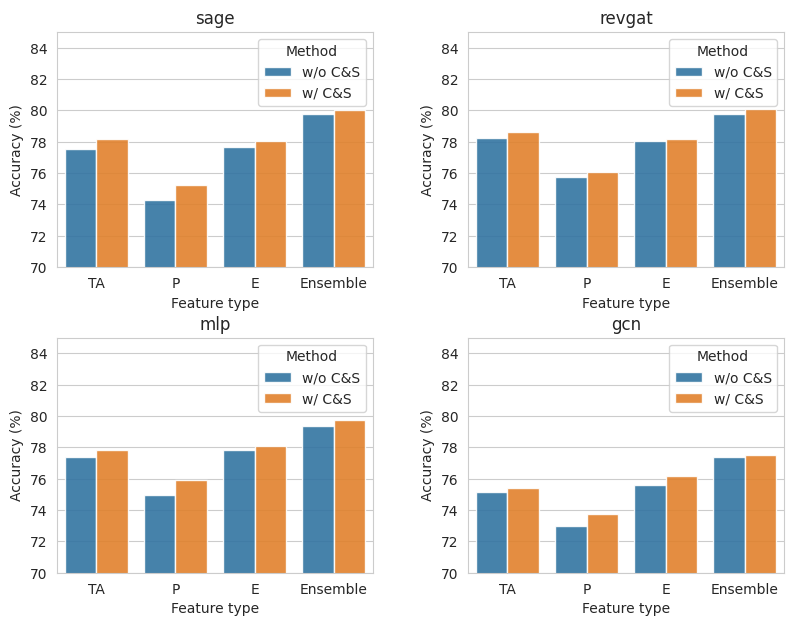

In [37]:
plotter = GridPlotter(nrows=-1, ncols=2, figsize=(8, 6), tight_layout=True)
file_list = [fname for fname in os.listdir(RESULT_DIR) if fname.endswith(".txt")]
for fname, ax in zip(file_list, plotter.iteraxs(len(file_list))):
    dataset, gnn = Path(fname).stem.rsplit("_", 1)
    result = {"Feature type": [], "Method": [], "Accuracy (%)": []}
    with open(RESULT_DIR / fname) as f:
        for line in f:
            match = re.search(r"TestACC: ([0-9\.]+)", line)
            if match:
                test_acc = float(match.group(1)) * 100
                _, _, feature_type, cas = re.search(r"\[(.+?)\+(.+?)\+(.+?)(?:\+(C&S))*\]", line).groups()
                result["Feature type"].append(feature_type)
                result["Method"].append("w/ C&S" if cas else "w/o C&S")
                result["Accuracy (%)"].append(test_acc)
    df = pd.DataFrame(result).set_index("Feature type").loc[["TA", "P", "E", "Ensemble"]]
    g = sns.barplot(df, x="Feature type", y="Accuracy (%)", hue="Method", ax=ax, alpha=0.9)
    g.set_ylim(70, 85)
    g.set_title(gnn)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plotter.show()